In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from astropy.table import Table
import astropy.units as u


In [2]:
import arya
import surp
from surp.gce_math import is_high_alpha
from surp._globals import DATA_DIR


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


warning could not find subgiants at  /arc7/home/dboyea/surp/surp/../data/subgiants.csv


Apogee can be downloaded from https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits, and astroNN from https://data.sdss.org/sas/dr17/env/APOGEE_ASTRO_NN/apogee_astroNN-DR17.fits.

In [3]:
plt.rcParams["text.usetex"] = False

# Basic cleaning

In [4]:
filename = surp.DATA_DIR + "/surveys/allStar-dr17-synspec_rev1.fits"

In [5]:
filename_ann = surp.DATA_DIR + "/surveys/apogee_astroNN-DR17.fits"


## Double check sha (optional)

In [6]:
check_sha = True

In [11]:
if check_sha:
    import subprocess
    result = subprocess.run(["sha1sum", filename], stdout=subprocess.PIPE)
    
    sha = result.stdout.decode().split(" ")[0]
    
    print("apogee matches ", sha == "7aa2f381de0e8e246f9833cc7da540ef45096702") # shasum from file


    result = subprocess.run(["sha1sum", filename_ann], stdout=subprocess.PIPE)
    sha = result.stdout.decode().split(" ")[0]
    print("ANN matches ", sha == "c422b9adba840b3415af2fe6dec6500219f1b68f") # shasum from file

apogee matches  True
ANN matches  True


## Loading and basic cleaning

In [12]:
allStar = Table.read(filename, format="fits", hdu=1, memmap=True)

In [13]:
def bracket(df, ele, ele2="H"):
    """
    Helper function for subgiants()
    creates the abundance ratio [A/B]
    from the  APOGEE dataframe
    """
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [14]:
df = allStar

# Add useful abundance ratios
df["O_H"] = bracket(df, "O")
df["MG_H"] = bracket(df, "MG")
df["C_O"] = bracket(df, "C", "O")
df["C_MG"] = bracket(df, "C", "MG")
df["C_H"] = bracket(df, "C", "H")

df["C_N"] = bracket(df, "C", "N")
df["N_H"] = bracket(df, "N", "H")
df["N_O"] = bracket(df, "N", "O")
df["N_MG"] = bracket(df, "N", "MG")

df["FE_O"] = -df["O_FE"]
df["FE_MG"] = -df["MG_FE"]

df["C_MG_ERR"] = df["C_FE_ERR"] + df["MG_FE_ERR"]
df["N_MG_ERR"] = df["N_FE_ERR"] + df["MG_FE_ERR"]
df["C_N_ERR"] = df["N_FE_ERR"] + df["C_FE_ERR"]
df["MG_H_ERR"] = df["MG_FE_ERR"] + df["FE_H_ERR"]
df["C_H_ERR"] = df["C_FE_ERR"] + df["FE_H_ERR"]

# add high/low alpha column
df["high_alpha"] = is_high_alpha(df["MG_FE"], df["FE_H"])

allStar = df

del df

### Bitmasks

See bitmasks in https://www.sdss4.org/dr17/irspec/apogee-bitmasks/#APOGEE_PARAMFLAG

'ancillary young embedded cluster member', 'ancillary emission line star', 'MIR-detected candidate cluster member (ancillary)', 

APOGEE2_Target3: 'Selected as part of the EB program', 'Selected as part of the young cluster study (IN-SYNC)', 'Ancillary W3/4/5 star forming complex'

              

Finally, I restrict to the given Log(g)-Teff domain:
log(g) ≥ 3.5
log(g) ≤ 0.004 ∗ (𝑇eff ) − 15.7
log(g) ≤ 0.00070588 ∗ (𝑇eff ) + 0.358836
log(g) ≤ −0.0015 ∗ (𝑇eff ) + 12.05
log(g) ≥ 0.0012 ∗ (𝑇eff ) − 2.8

In [15]:
apogee_aspcapflag = 0

# apogee_aspcapflag ^= 1<<23 # STAR_BAD (TEFF, LOGG, CHI2, COLORTE, ROTATION, SN, GRIDEDGE_BAD)


In [16]:
# starflag is a bitwise and for each visit

apogee_starflag = 0

# these don't help
# apogee_starflag ^= 1<<18 # bad_rv_companion
# apogee_starflag ^= 1<<22 # RV_FAIL

In [17]:
apogee_target2 = 0

apogee_target2 ^= 1<<17 # APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 # APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 # APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

In [18]:
apogee2_target3 = 0

apogee2_target3 ^= 1<<1 # APOGEE2_EB eclipsing binary program
apogee2_target3 ^= 1<<5 # APOGEE2_YOUNG_CLUSTER # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 # APOGEE2_W345 W3/4/5 star forming complex


In [19]:
extratarg = 1<<4 # DUPLICATE (keeps highest S/N observation)

In [20]:
elem_flag = 0
# elem_flag ^= 1<<0 # GRIDEDGE_BAD	0	Parameter within 1/8 grid spacing of grid edge : true value may be off grid
# elem_flag ^= 1<<1 # CALRANGE_BAD	1	Parameter outside valid range of calibration determination
# elem_flag ^= 1<<2 # OTHER_BAD	2	Other error condition
# elem_flag ^= 1<<3 # FERRE_FAIL	3	Failed solution in FERRE
# elem_flag ^= 1<<4


In [21]:
print(bin(apogee2_target3))
print(bin(apogee_target2))
print(bin(apogee_starflag))
print(bin(apogee_aspcapflag))
print(bin(extratarg))
print(bin(elem_flag))

0b1000000000000100010
0b101010000000000000
0b0
0b0
0b10000
0b0


In [22]:
mask = np.full(len(allStar), True)
print(sum(~mask))

mask &= (allStar["ASPCAPFLAG"] & apogee_aspcapflag) == 0
print(sum(~mask))

mask &= (allStar["STARFLAG"] & apogee_starflag) == 0
print(sum(~mask))

mask &= (allStar["APOGEE2_TARGET3"] & apogee2_target3) == 0
print(sum(~mask))

mask &= (allStar["APOGEE_TARGET2"] & apogee_target2) == 0
print(sum(~mask))


mask &= (allStar["EXTRATARG"] & extratarg) == 0


mask &= (allStar["FE_H_FLAG"] & elem_flag) == 0
print(sum(~mask))

mask &= (allStar["MG_FE_FLAG"] & elem_flag) == 0
print(sum(~mask))

mask &= (allStar["C_FE_FLAG"] & elem_flag) == 0
print(sum(~mask))


print(sum(~mask))
print("remaining ", sum(mask))

0
0
0
12470
16219
90425
90425
90425
90425
remaining  643476


In [23]:
np.sum(~np.isfinite(allStar[mask]["FE_H"]))

np.int64(66735)

In [24]:
for col in ["FE_H", "MG_FE", "C_FE", "N_FE", "LOGG", "TEFF"]:
    print(col)
    mask &= np.isfinite(allStar[col])
    mask &= np.isfinite(allStar[col + "_ERR"])
    print(sum(~mask))
    print()

FE_H
157160

MG_FE
157778

C_FE
160196

N_FE
207002

LOGG
207002

TEFF
207002



In [25]:
print(sum(mask))

526899


In [26]:
allStarClean = allStar[mask]
names = [name for name in allStarClean.colnames if len(allStarClean[name].shape) <= 1]
allStarClean = allStarClean[names]

In [27]:
len(allStarClean)

526899

## Reading in astroNN

In [28]:
astroNN = Table.read(filename_ann, format="fits", hdu=1, memmap=True)

names = [name for name in astroNN.colnames if len(astroNN[name].shape) <= 1]
astroNN = astroNN[names].to_pandas()

In [29]:
astroNN = astroNN[~astroNN["APOGEE_ID"].duplicated(keep="last")].copy()

In [30]:
astroNN.set_index("APOGEE_ID", inplace=True)
astroNN.columns = astroNN.columns.map(lambda x: str(x) + '_ANN')

In [31]:
astroNN

,LOCATION_ID_ANN,TELESCOPE_ANN,RA_APOGEE_ANN,DEC_APOGEE_ANN,TEFF_ANN,TEFF_ERR_ANN,LOGG_ANN,LOGG_ERR_ANN,C_H_ANN,C_H_ERR_ANN,...,theta_phi_ANN,theta_phi_err_ANN,theta_z_ANN,theta_z_err_ANN,rl_ANN,rl_err_ANN,Energy_ANN,Energy_err_ANN,EminusEc_ANN,EminusEc_err_ANN
APOGEE_ID,,,,,,,,,,,,,,,,,,,,,
b'VESTA',1,b'apo1m',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'2M00000002+7417074',5046,b'apo25m',0.000103,74.285408,3730.434814,49.411095,0.864455,0.091876,-0.151543,0.032733,...,0.162341,0.002044,1.257675,0.029077,9.313814,0.104881,-35566.630438,541.664052,-53127.445881,237.718629
b'2M00000019-1924498',5071,b'apo25m',0.000832,-19.413851,5517.530273,136.336548,4.045386,0.218193,-0.239434,0.041846,...,6.186121,0.014669,3.736751,0.015291,7.512346,0.151292,-44554.547150,644.013746,-56067.037371,67.716759
b'2M00000032+5737103',4264,b'apo25m',0.001335,57.619530,6184.383301,159.639954,3.765513,0.169739,-0.189551,0.034528,...,0.107335,0.000205,4.069535,0.015443,8.940202,0.004568,-38034.879007,22.339314,-54482.585262,8.342593
b'2M00000035-7323394',7218,b'lco25m',0.001467,-73.394287,4473.471191,151.328293,1.654428,0.448441,-1.750013,0.298410,...,14.588887,316.082670,14.995901,316.069555,6.411104,2.007341,-4029.752908,16425.789087,-7247.884378,21167.997105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'2M23595886-2009435',5071,b'apo25m',359.995258,-20.162107,4385.419922,18.942038,1.607170,0.051512,-0.573421,0.042118,...,5.245957,0.035109,4.489594,0.019772,2.715510,0.173466,-26309.039393,1459.584798,-3208.330021,3927.172429
b'2M23595886+5726058',4424,b'apo25m',359.995265,57.434956,6205.649902,156.622910,4.093451,0.166493,-0.372012,0.037212,...,0.241518,0.001445,3.770612,0.034564,8.343132,0.059089,-40588.051794,297.780679,-55113.572201,98.472122
b'2M23595921+5609479',-999,b'apo25m',359.996744,56.163330,4981.779297,46.355877,3.056617,0.102835,-0.286302,0.041631,...,0.255623,0.002026,5.967744,0.008252,9.237442,0.083535,-36290.481852,387.265723,-53629.147394,141.979567


In [32]:
len(astroNN) == len(astroNN.index.unique())

True

Text(0, 0.5, 'teff')

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of

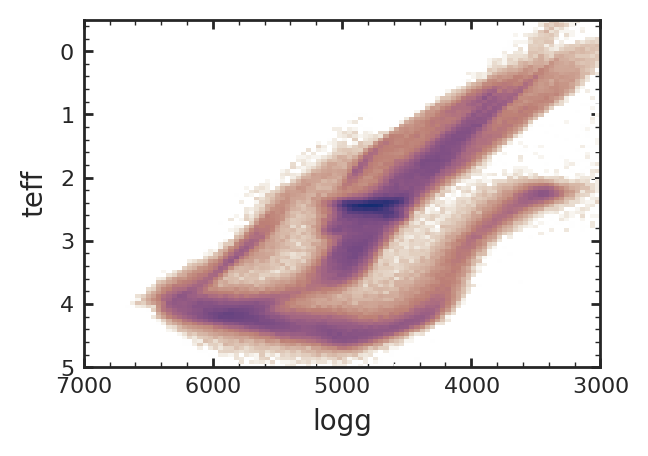

In [33]:
plt.hist2d(astroNN["TEFF_ANN"], astroNN["LOGG_ANN"], range=((3000, 7000), (-0.5, 5)), bins=100, norm="log", cmin=3, cmap=arya.style.get_cmap(to_white=True, reverse=True));

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("logg")
plt.ylabel("teff")

# APOGEE alla jack

Jack's coordinates are

- (3.5, 4800)
- (3.8, 4875)
- (4.1, 5300)
- (3.8, 5500)
- (3.5, 5250)


In [34]:
logg = allStarClean["LOGG"]
teff = allStarClean["TEFF"]

mask = logg >= 3.5
mask &= logg <= 0.004*teff - 15.7
mask &= logg <= 0.0007*teff + 0.36
mask &= logg <= -0.0015 * teff + 12.05
mask &= logg >= 0.0012*teff - 2.8

In [35]:
np.sum(mask)

np.int64(14066)

In [36]:
subgiants = allStarClean[mask].to_pandas()

In [37]:
np.sum(subgiants.APOGEE_ID.duplicated())

np.int64(0)

In [38]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.1, 5300),
    (3.8, 5500),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'se

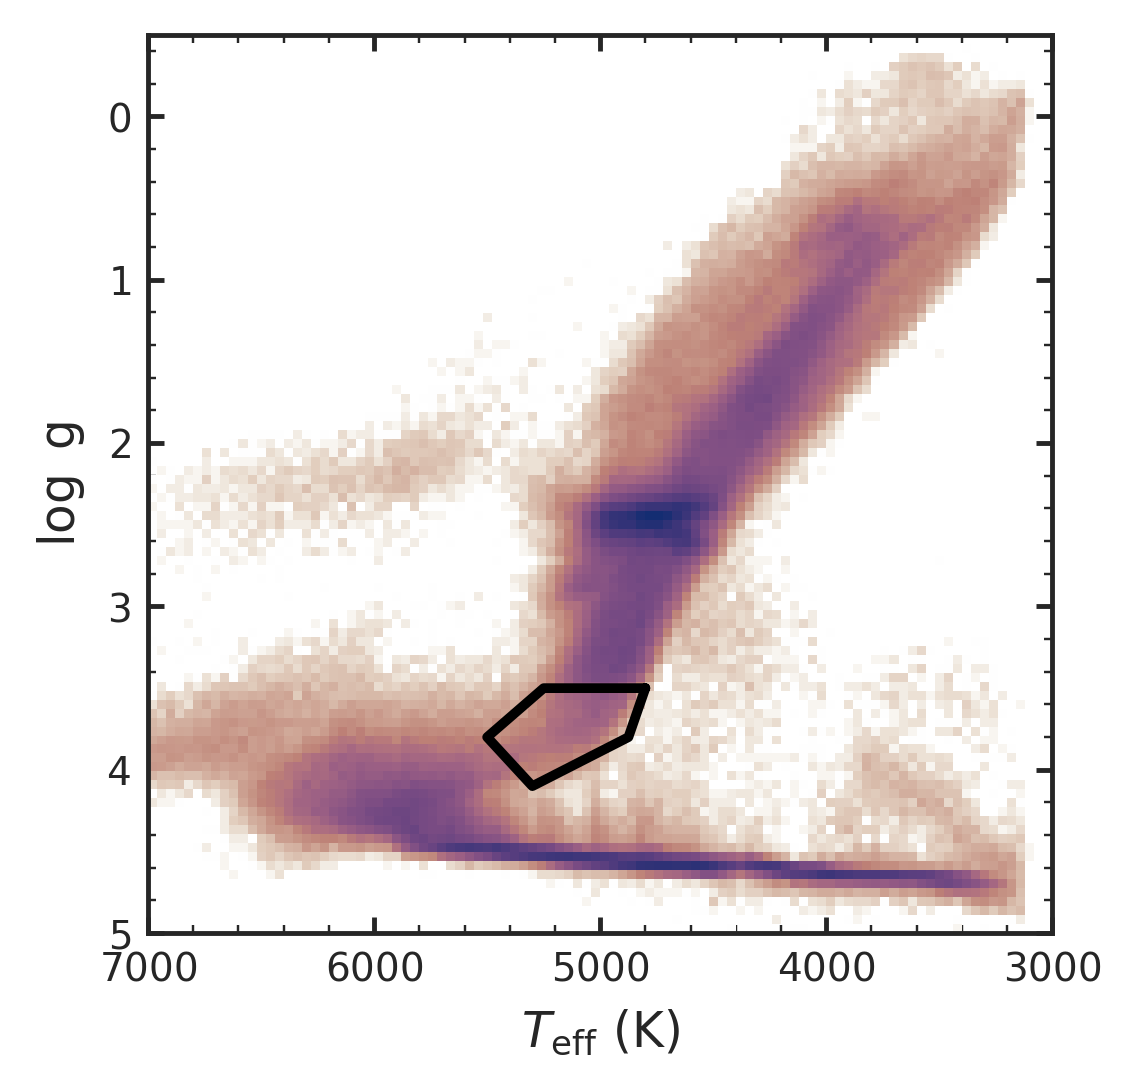

In [39]:
plt.figure(figsize=(10/3, 10/3), rasterized=True, dpi=350)
_, _, _, img = plt.hist2d(allStar["TEFF"], allStar["LOGG"], range=((3000, 7000), (-0.5, 5)), bins=100, norm="log", cmin=3, cmap=arya.style.get_cmap(to_white=True, reverse=True))
img.set_edgecolor("none")


plt.plot(x, y, lw=2, color="k")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_{\\rm eff}$ (K)")
plt.ylabel("$\\log$ g")
plt.savefig("logg_jack.pdf")

Text(0, 0.5, '$\\log$ g')

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


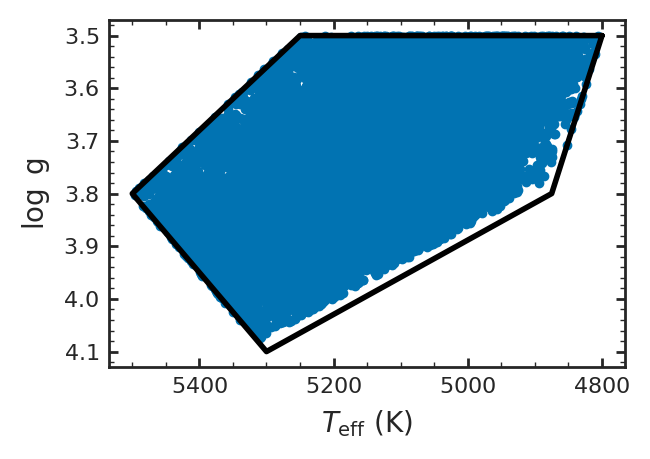

In [40]:
plt.plot(x, y, lw=2, color="k")
plt.scatter(subgiants.TEFF, subgiants.LOGG)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_{\\rm eff}$ (K)")
plt.ylabel("$\\log$ g")

In [41]:
subgiants_pann = subgiants.set_index("APOGEE_ID").join(astroNN).copy()


In [42]:

subgiants_pann["R_gal"] = subgiants_pann.galr_ANN
subgiants_pann["z_gal"] = subgiants_pann.galz_ANN

subgiants_pann["abs_z"] = np.abs(subgiants_pann.z_gal)

In [43]:
import astropy.coordinates as ac
import astropy.units as u

In [44]:
d =  1 * u.kpc/subgiants_pann.GAIAEDR3_PARALLAX.values

In [45]:
d[d<0] = np.nan

In [46]:
sc = ac.SkyCoord(ra=subgiants_pann.RA.values * u.deg, dec=subgiants_pann.DEC.values * u.deg, distance =d)

gc = sc.transform_to(ac.Galactocentric())

In [47]:
R = (np.sqrt(gc.x**2 + gc.y**2) / u.kpc).decompose().value

In [48]:
z = (gc.z / u.kpc).decompose().value

In [49]:
subgiants_pann["R_gal_gaia"] = R
subgiants_pann["z_gal_gaia"] = z

In [50]:
len(subgiants_pann)

14066

In [51]:
subgiants_pann.to_csv(DATA_DIR + "subgiants.csv")

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


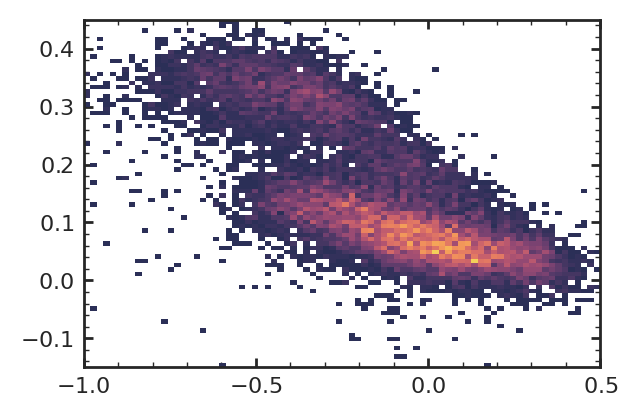

In [52]:
plt.hist2d(subgiants.FE_H, subgiants.MG_FE, cmin=1, bins=80, range=((-1, 0.5),(-0.15, 0.45)) );


In [53]:
import seaborn as sns

<Axes: xlabel='R_gal', ylabel='Density'>

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


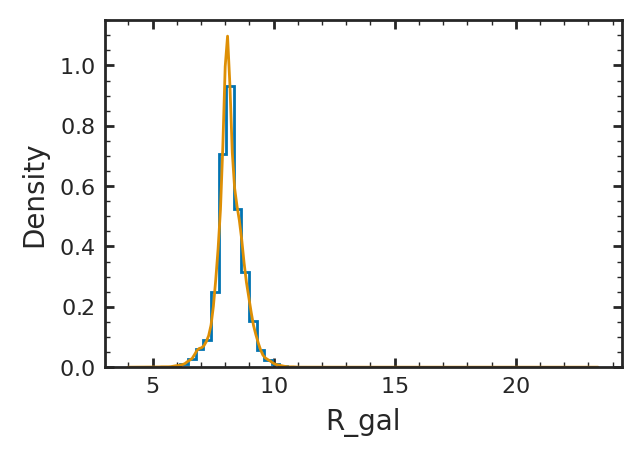

In [54]:
plt.hist(subgiants_pann.R_gal, histtype="step", bins=60, density=True)
sns.kdeplot(subgiants_pann.R_gal)


<Axes: xlabel='z_gal', ylabel='Density'>

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


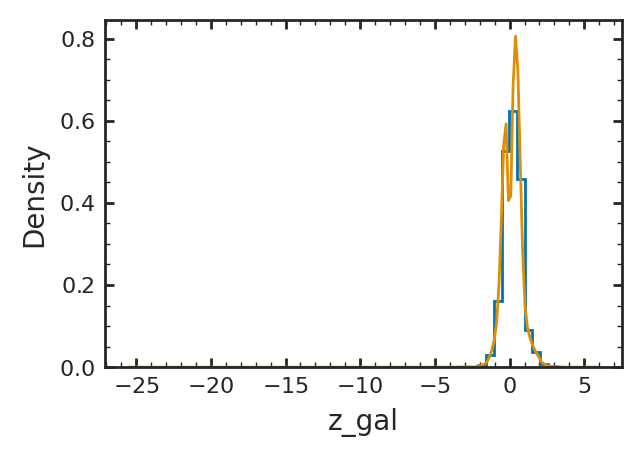

In [55]:
plt.hist(subgiants_pann.z_gal, histtype="step", bins=60, density=True)
sns.kdeplot(subgiants_pann.z_gal)


# Validation

In [56]:
import surp
import matplotlib.pyplot as plt
import seaborn as sns
import arya

In [57]:
import numpy as np

In [62]:
subgiants = surp.subgiants

In [60]:
subgiants[~np.isclose(subgiants_pann.R_gal, subgiants.R_gal.values)]

AttributeError: 'NoneType' object has no attribute 'R_gal'

In [ ]:
sns.kdeplot(subgiants.R_gal)
sns.kdeplot(subgiants_pann.R_gal, ls=":")

plt.xlabel("R ga")


In [ ]:
plt.scatter(R, subgiants.R_gal, s=1, alpha=0.3)
plt.xlim(0, 13)
plt.ylim(0, 13)
plt.plot([0,13],[0,13], "k-")

In [ ]:
sns.kdeplot(R, clip=(0, 15), label="Gaia")
sns.kdeplot(subgiants_pann.R_gal, label="ANN")
plt.xlim(0, 15)
plt.xlabel("R ga")
plt.legend()

In [ ]:
sum(subgiants_pann.abs_z > 3) / len(subgiants_pann)

In [ ]:
sns.kdeplot((z), label="gaia", clip=(-3, 3))

sns.kdeplot(subgiants_pann.z_gal, label="ANN", clip=(-3, 3))
plt.xlabel("z ga")
plt.legend()

In [ ]:
assert len(subgiants_pann) == surp.N_SUBGIANTS